In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip gdrive/'My Drive'/figshare-dataset.zip

<h3>Importing Required Libraries</h3>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.transforms import Compose, ToTensor
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.metrics import f1_score, precision_score, recall_score

<h3>Accessing the Train and Validation Data </h3>

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

splitfolders.ratio('figshare-dataset', output="figshare-split", seed=1337, ratio=(.7, .1, .2))

Copying files: 3064 files [00:01, 1607.23 files/s]


In [ ]:
train_path = "figshare-split/train"
valid_path = "figshare-split/val"
test_path = "figshare-split/test"

<h4>Defining the data transformations</h4>

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

<h4>Creating the Datasets </h4>

In [ ]:
image_datasets = {x: torchvision.datasets.ImageFolder(eval(f"{x}_path"), transform) for x in ['train', 'valid','test']}

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'valid','test']}

<h3> Visualising the Classes of Tumor </h3>

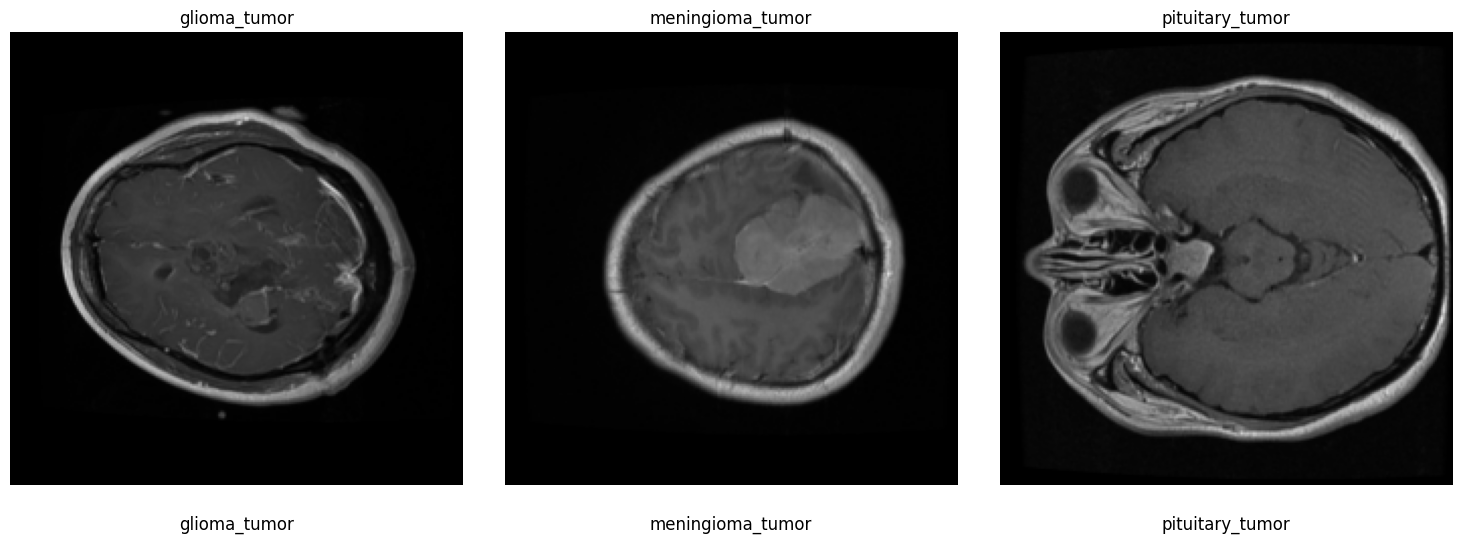

In [ ]:
def visualize_class_samples(dataset):
    classes = dataset.classes

    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

    # Loop through each class
    for i, cls in enumerate(classes):
        indices = np.where(np.array(dataset.targets) == i)[0]  # Indices of samples in this class
        selected_idx = np.random.choice(indices, size=1, replace=False)[0]  # Choose one image index

        image, _ = dataset[selected_idx]
        ax = axes[i]
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))  # Transpose to (H, W, C)
        ax.set_title(cls)
        ax.axis('off')

        ax.text(0.5, -0.1, cls, transform=ax.transAxes, fontsize=12, ha='center')

    plt.tight_layout()
    plt.show()

visualize_class_samples(image_datasets['train'])

In [ ]:
vgg19_model = models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
new_out_features=4096
vgg19_model.classifier[6] = nn.Linear(4096, new_out_features)


In [ ]:
num_classes = 4

vgg19_model.classifier[3] = nn.Dropout(0.5)
in_features = vgg19_model.classifier[6].in_features
vgg19_model.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 4096),
    nn.ReLU(inplace=False),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=False),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes),
)

for param in vgg19_model.features.parameters():
    param.requires_grad = False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
vgg19_model = vgg19_model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19_model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
num_epochs = 20

In [ ]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            vgg19_model.train()
        else:
            vgg19_model.eval()

        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg19_model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(dataloaders[phase])
        epoch_accuracy = correct / total

        print(f'{phase.capitalize()} Epoch {epoch + 1}/{num_epochs}, '
              f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Collect losses and accuracies for plotting
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)
        else:
            valid_losses.append(epoch_loss)
            valid_accuracies.append(epoch_accuracy)

    scheduler.step()

Train Epoch 1/20, Loss: 0.8873, Accuracy: 0.5905
Valid Epoch 1/20, Loss: 0.4470, Accuracy: 0.8131
Train Epoch 2/20, Loss: 0.4861, Accuracy: 0.7994
Valid Epoch 2/20, Loss: 0.2950, Accuracy: 0.8689
Train Epoch 3/20, Loss: 0.4055, Accuracy: 0.8288
Valid Epoch 3/20, Loss: 0.2746, Accuracy: 0.8852
Train Epoch 4/20, Loss: 0.3869, Accuracy: 0.8484
Valid Epoch 4/20, Loss: 0.2599, Accuracy: 0.8918
Train Epoch 5/20, Loss: 0.3452, Accuracy: 0.8577
Valid Epoch 5/20, Loss: 0.2353, Accuracy: 0.8984
Train Epoch 6/20, Loss: 0.2850, Accuracy: 0.8885
Valid Epoch 6/20, Loss: 0.2642, Accuracy: 0.8852
Train Epoch 7/20, Loss: 0.2632, Accuracy: 0.8927
Valid Epoch 7/20, Loss: 0.2270, Accuracy: 0.9016
Train Epoch 8/20, Loss: 0.2393, Accuracy: 0.9007
Valid Epoch 8/20, Loss: 0.2021, Accuracy: 0.9148
Train Epoch 9/20, Loss: 0.2204, Accuracy: 0.9146
Valid Epoch 9/20, Loss: 0.2104, Accuracy: 0.9082
Train Epoch 10/20, Loss: 0.2056, Accuracy: 0.9212
Valid Epoch 10/20, Loss: 0.2104, Accuracy: 0.9016
Train Epoch 11/20,

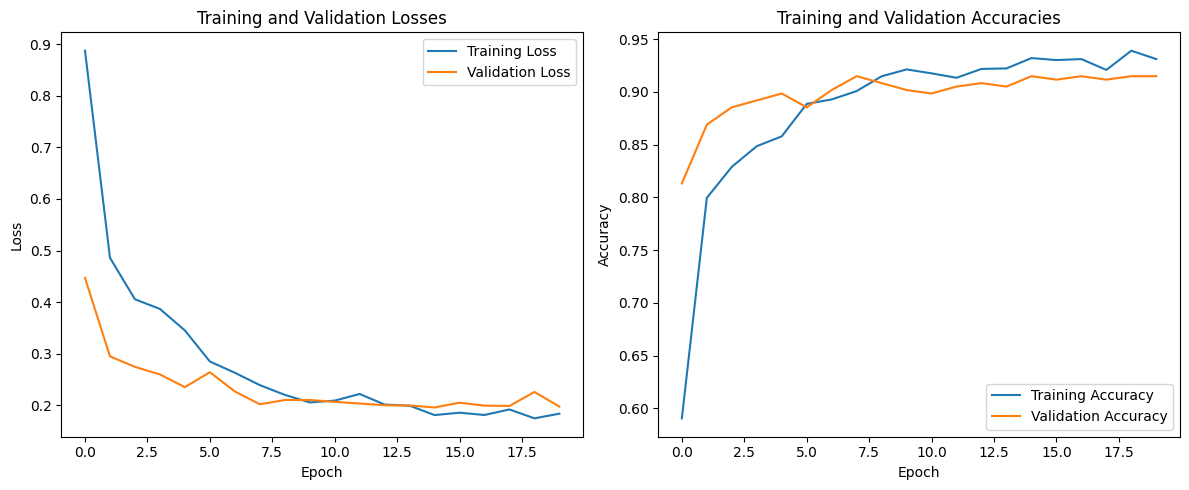

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Call the function to get the test accuracy
test_accuracy = evaluate_test_accuracy(vgg19_model, dataloaders['test'])
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9041


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

vgg19_model.eval()
all_preds_test = []
all_labels_test = []

with torch.no_grad():

  for inputs, labels in dataloaders['test']:

    inputs, labels = inputs.to(device), labels.to(device)
    outputs = vgg19_model(inputs)

    all_preds_test.extend(torch.argmax(outputs, dim=1).cpu().numpy())
    all_labels_test.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels_test, all_preds_test)
print(f"Test Accuracy : {test_accuracy}")

print("Classification Report:")
print(classification_report(all_labels_test, all_preds_test))



Test Accuracy : 0.9040650406504065
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       286
           1       0.84      0.73      0.78       143
           2       0.92      0.98      0.95       186

    accuracy                           0.90       615
   macro avg       0.89      0.89      0.89       615
weighted avg       0.90      0.90      0.90       615



In [ ]:
def predict_class(image_path):
    # Load an image
    image = Image.open(image_path).convert('RGB')

    # Preprocess the image
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0).to(device)  # Move the input tensor to the appropriate device

    # Perform prediction
    with torch.no_grad():
        output = vgg19_model(input_batch)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)

    return predicted_class.item()


In [ ]:
image_path = '/content/split_data/test/meningioma_tumor/114.png'  # Replace with the actual image path
predicted_class = predict_class(image_path)

class_names = ['Glioma Tumor', 'Meningioma Tumor', 'No Tumor' , 'Pituitary Tumor']

print(f'Predicted Class: {class_names[predicted_class]}')

Predicted Class: Meningioma Tumor


In [ ]:
num_trainable_params = sum(p.numel() for p in vgg19_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_trainable_params}')

Number of trainable parameters: 136343556
